<a href="https://www.kaggle.com/code/mcadriaans/binary-classification-credit-card-fraud?scriptVersionId=194882852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<font size=6><b> Binary Classification : Credit Card Fraud Detection</b>

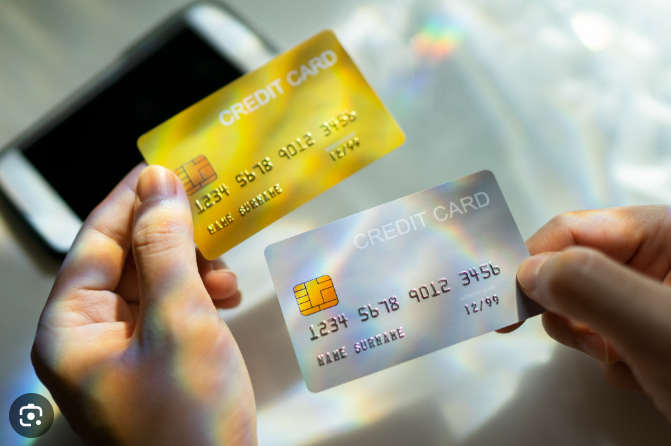

# <b>About the Data</b>

This dataset analyzes credit card transactions in Europe during September 2013, focusing on a two-day period. It includes a small percentage of fraudulent transactions (0.172%, or 492 out of 284,807).

To protect sensitive information, the data has been transformed using Principal Component Analysis (PCA). This technique creates new features (V1 to V28) that represent the original data in a numerical format. Only the 'Time' (seconds since the first transaction) and 'Amount' (transaction value) remain in their original form.

The 'Class' feature indicates whether a transaction is fraudulent (1) or legitimate (0). Due to the significant imbalance between fraudulent and legitimate transactions, standard accuracy is not the most reliable evaluation metric. Precision, Recall, or F1-score may be more suitable for assessing the model's performance.

# <b>Load Data</b>

## Import Kaggle Data Sources

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


## Load Dependencies


In [2]:
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV


## Load Data

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
## Dimensions of the data
df.shape

(284807, 31)

In [5]:
## Summary of data structure (data types, non-null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<font size=5 color=darkcyan><b><u>Observations</u></b></font>
* All Features and the target are numeric.</font>
* There are no missing values in the data.</font>

# <b>Data Cleaning</b>

## Handle Duplicates

In [6]:
len(df)

284807

In [7]:
## Check for duplicates
df.duplicated().any()

True

In [8]:
## Drop duplicates
df = df.drop_duplicates()
len(df)

283726

## Remove Unneccesary Columns

We drop the 'Time' column to simplify the dataset.

In [9]:
## Drop unneccessary column
df = df.drop(['Time'], axis=1)

# <b>Exploratory Data Analysis</b>

## Statistical Summary

In [10]:
## Summary statistics of the data
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


##  Distribution of Amount

In [11]:
df['Amount'].describe()

count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
## Create a box plot
fig = px.box(df, y='Amount', title='Box Plot of Amount')
## Update plot layout
fig.update_layout(
    autosize=False,
    width = 400,
    height=400,
    title_x = 0.5,
    title_y = 0.9
)
fig.show()

<font size=5 color=darkcyan><b><u>Observations</u></b></font>

The `Amount`variable has several outliers, indicated by distinct points significantly distant from the main cluster of data. Given this distribution, using RobustScaler is more appropriate. RobustScaler is less sensitive to outliers because it uses the median and interquartile range for scaling, making it a better choice for datasets with notable outliers.

## Target variable analysis

The `Class` target variable identifies fraudulent transactions (value 1) and legitimate ones (value 0).

In [13]:
## Examine the target variable
target_counts = df['Class'].value_counts()
index_dict = {1 : 'Fraudulent', 0: 'Legitimate'}
target_counts.index = target_counts.index.map(index_dict)
target_counts

Class
Legitimate    283253
Fraudulent       473
Name: count, dtype: int64

In [14]:
fig = px.pie(target_counts,
             values=target_counts,
             names=target_counts.index)
for data in fig.data:
    data.hovertemplate = 'Class: %{label}<br>Total Count: %{value}'

## Update plot layout
fig.update_layout(
    autosize=False,
    width = 400,
    height=400,
    title_text = " Credit Card Transaction Classification",
    title_x = 0.1,
    title_y = 0.93,
    legend_title_text='Transaction Type',
    legend_x = -0.9,
    legend_y = 0.5
)

## Display plot
fig.show()

<font size=5 color=darkcyan><b><u>Observations</u></b></font>

* Majority class (legitimate): 99.8% - This represents a vast majority of the transactions.
* Minority class (fraudulent): 0.167% - This is a very small fraction of the total transactions.

This represents severe class imbalance, with such a small minority class, machine learning algorithms might struggle to learn its characteristics effectively. This can lead to poor performance in identifying fraudulent transactions.



# Feature Selection

## Correlation Analysis
The heatmap reveals intricate data relationships, shedding light on hidden patterns. Displaying this heatmap guides us in making informed decisions, a critical step in our analytical journey towards insights and discovery.

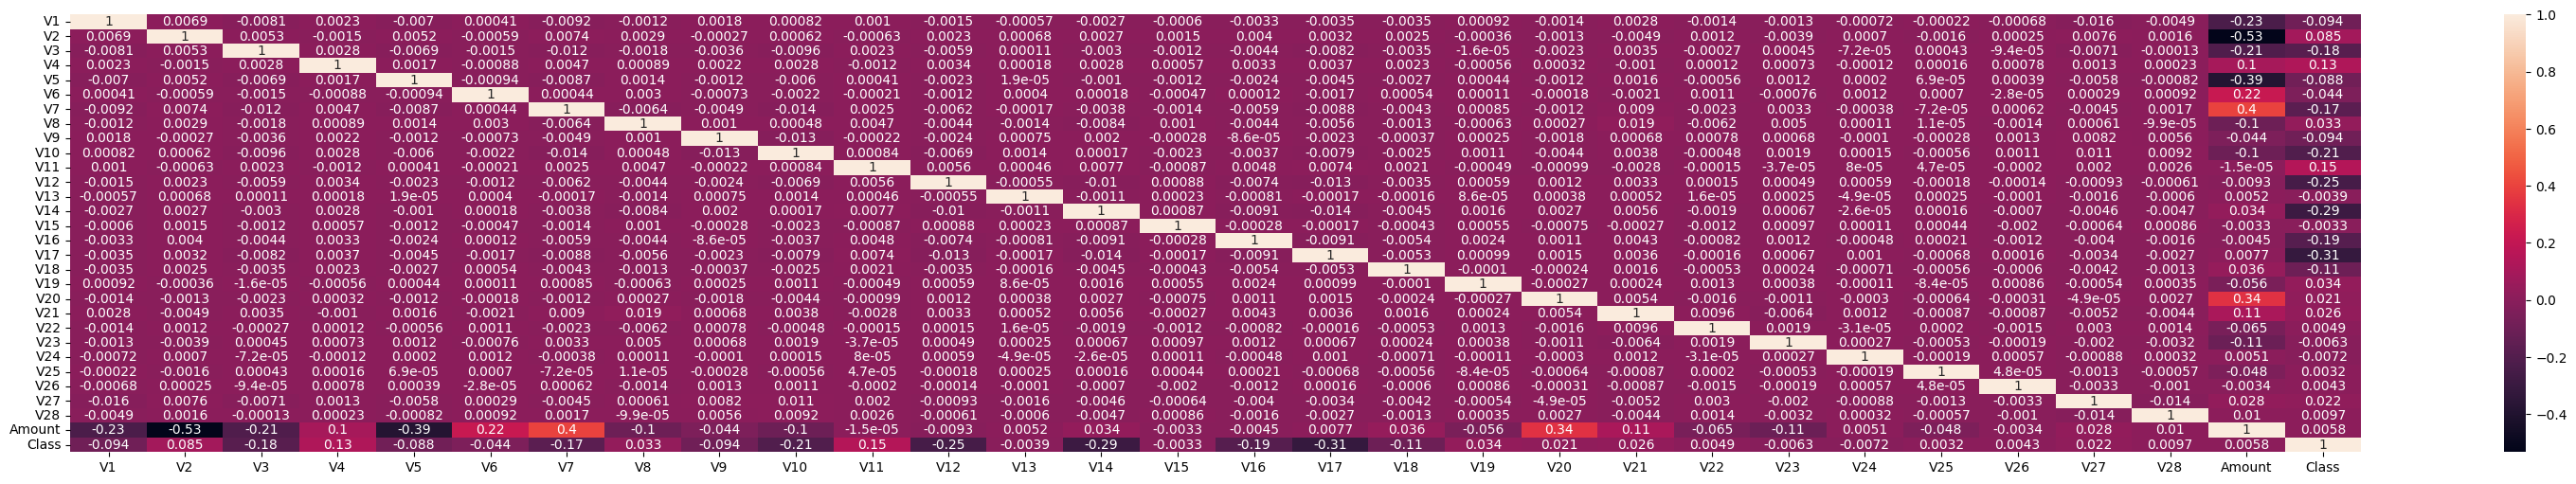

In [15]:
## Plot the correlation Matrix
corr_data = df.corr()

#plt.figure(figsize=(9,6))
plt.figure(figsize=(39,6))
## Create heat map
sns.heatmap(corr_data, annot=True)

## Display the plot
plt.show()

# <b> Model Building </b>

## Define Features and target

In [16]:
X = df.drop(['Class'], axis=1)
y = df['Class']

## Split into training and test splits


      Stratification: Ensures that both the training and testing sets have similar class distributions.
      This helps to prevent biases in model evaluation.

In [17]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

## Data Preprocessing

###  Feature Scaling

We do not need to apply standard scaling the PCA transformed features V1 through V28.PCA itself performs a form of standardization during its internal calculations.

In [18]:
## Create a RobustScaler object
scaler = RobustScaler()

## Fit and transform scaler on training data
X_train_0['Amount'] = scaler.fit_transform(X_train_0['Amount'].values.reshape(-1,1))

## Transform test data
X_test_0['Amount'] = scaler.transform(X_test_0['Amount'].values.reshape(-1,1))

## Model Selection

In [19]:
X_train = X_train_0
X_test = X_test_0
y_train = y_train_0
y_test = y_test_0

models = [LogisticRegression(random_state = 42, solver='liblinear'), LinearDiscriminantAnalysis(), GaussianNB(), XGBClassifier(random_state = 42) ]
model_names = ["Logistic Regression", "Linear Discriminant Analysis", "Gaussian Naive Bayes", "XGBClassifier"]

### Evaluate Model Performance: Plotting Precision-Recall Curves for Classifiers

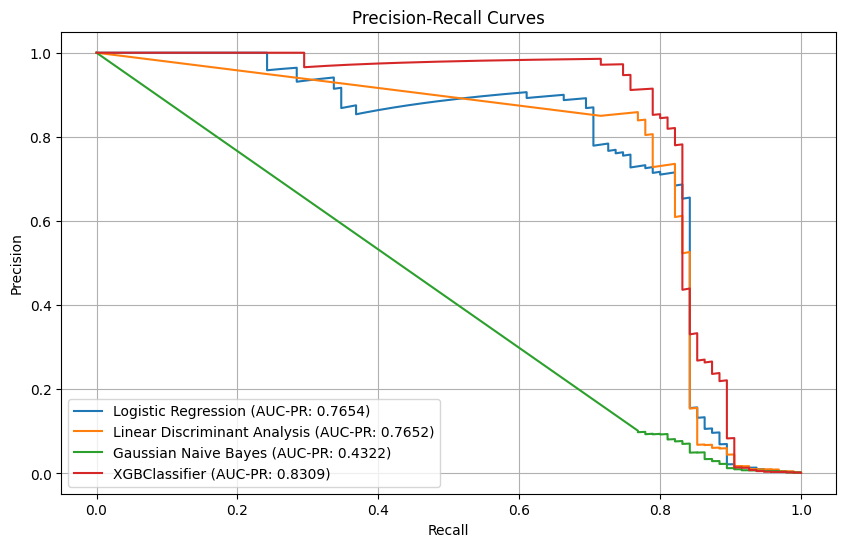

In [20]:
## Plot setup
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    ## Train the model
    model.fit(X_train, y_train)

    ## Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    ## Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    ## Calculate AUC-PR
    auc_pr = auc(recall, precision)

    ## Plot the precision-recall curve
    plt.plot(recall, precision, label=f"{model_names[i]} (AUC-PR: {auc_pr:.4f})")

## Label and show the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

The XGBClassifier boasts an AUC-PR (Area Under the Precision-Recall Curve) of 0.8309, which is notably higher than the other models. This indicates that it generally maintains a good balance between Precision and Recall across various threshold settings.
* **Consistent Precision as Higher Recalls**: The curve for XGBClassifier stays relatively high in Precision even when Recall increases. This suggests the model can effectively identify a substantial portion of positive instances( high recall) without compromising on the accuracy of those identifications (high precision)
* **Steeper Curve**: Compared to the other models , the XGBCLassifier's curve descends more steeply. This implies that as Recall increases, the Precision drops more rapidly.

The XGBClassifier demonstartes strong performance in terms of Precision and Recall. Its high AUC-PR score and ability to maintain reasonable Precision at higher Recall levels suggest it is a suitable choice for the classification task.

<font color=blue>Next Step: We can select the XGBoost Classifier and experiment further.</font>

### Study the best model

<b>Cost of Misclassification in Credit Card Fraud Detection</b>: <font color=red>False Negatives(Missed Fraud)</font> is generally considered the more critical error in credit card fraud detection when compared to False Positives(An actual legitimate transaction is predicted to be fraudulent). So, our aim is to maximize the Recall for Class 1.

The Matthews Correlation Coefficient (MCC) is a metric used to evaluate the quality of binary classifications.MCC is effective in evaluating models for fraud detection where fraudulent transactions are much fewer than legitimate ones.It provides a more informative and truthful score in such cases compared to other metrics like accuracy.

In [21]:
## Initialize empty lists to store values for summary of results dataframe

model_description= []
precision_class_1 = []
recall_class_1 = []
f1_score_class_1 = []
auc_scores = []
mcc_scores = []

## Define a function that calculates and stores evaluation metrics for a given model

def results(md, model, Xtrain, ytrain, Xtest,  ytest):
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    print("Confusion Matrix:\n\n", confusion_matrix(ytest, ypred))
    print("\n\nClassification report:\n\n" ,classification_report(ytest, ypred, target_names=['Legitimate', 'Fraudulent']))

    cr = classification_report(ytest, ypred, output_dict=True)
    model_description.append(md)
    p = round(cr['1']['precision'],2)
    precision_class_1.append(p)
    r = round(cr['1']['recall'], 2)
    recall_class_1.append(r)
    f = round(cr['1']['f1-score'],2)
    f1_score_class_1.append(f)

    # AUC score
    y_predproba = model.predict_proba(Xtest)[:, 1]
    a = round(roc_auc_score(ytest,y_predproba ),2)
    auc_scores.append(a)

    # Matthews Correlation Coefficient
    m = round(matthews_corrcoef(ytest, ypred), 2)
    mcc_scores.append(m)
    cr_comparison_df = pd.DataFrame({
     "Model" : model_description,
     "Precision(Class 1)" : precision_class_1,
     "Recall (Class 1)": recall_class_1,
     "F1-score (Class 1)": f1_score_class_1,
     "AUC score" : auc_scores,
     "MCC" : mcc_scores
  })

   # Calculate accuracy scores
    print('Check whether the model is overfitting:')
    y_train_pred = model.predict(Xtrain)
    y_test_pred = model.predict(Xtest)
    train_accuracy = accuracy_score(ytrain, y_train_pred)
    test_accuracy = accuracy_score(ytest, y_test_pred)
    print(f'Train accuracy: {(train_accuracy * 100):.2f} %')
    print(f'Test accuracy: {(test_accuracy * 100):.2f} %')
    if train_accuracy > test_accuracy:
        accuracy_gap = train_accuracy - test_accuracy
        if accuracy_gap < 0.05:
            print("Model generalizes well.")
        elif accuracy_gap < 0.10:
            print("Model has moderate overfitting.")
        else: print("Model has severe overfitting.")
    elif training_accuracy < test_accuracy:
            print("Model is underfitting.")
    else:
        print("Model performs well.")
    print("\n\nSummary of results (Fraudulent transactions:)")
    return cr_comparison_df


#### <u>Baseline XGBoost model without addressing class imbalance</u>

In [22]:
model = XGBClassifier(random_state=42)
results("Baseline", model, X_train, y_train, X_test,  y_test)


Confusion Matrix:

 [[56644     7]
 [   22    73]]


Classification report:

               precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
  Fraudulent       0.91      0.77      0.83        95

    accuracy                           1.00     56746
   macro avg       0.96      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Check whether the model is overfitting:
Train accuracy: 100.00 %
Test accuracy: 99.95 %
Model generalizes well.


Summary of results (Fraudulent transactions:)


,Model,Precision(Class 1),Recall (Class 1),F1-score (Class 1),AUC score,MCC
0,Baseline,0.91,0.77,0.83,0.96,0.84


      * Precision (Class 1): Proportion of positive predictions that were truly positive (fraudulent transactions).
      * Recall (Class 1): Proportion of actual positives (fraudulent transactions) that were correctly identified.
      * F1-Score (Class 1): Harmonic mean of precision and recall, balancing both metrics.
      * AUC-ROC: Area Under the Receiver Operating Characteristic curve,1 generally used for imbalanced datasets.



<font color=blue><b>Next Step</b>:  Implement the baseline model with SMOTE (Oversampling the minority class) to see whether we can enhance the model's performance.</font>

#### <u> XGBoost model + SMOTE</u>



SMOTE prepares the data for model training by addressing the class imbalance issue. It involves oversampling the minority class using  and training the XGBoost model with the resampled training data.

In [23]:
from imblearn.over_sampling import BorderlineSMOTE

#smote = SMOTE(random_state=42)
#smote = SMOTE(k_neighbors=3, sampling_strategy=0.9, random_state=42)
smote = BorderlineSMOTE(kind='borderline-1', sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#print(y_train.value_counts())   # Count for original y_train
#print(y_train_res.value_counts()) # Count for resampled y_train

model = XGBClassifier(random_state=42)
results("Baseline+SMOTE", model, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix:

 [[56638    13]
 [   18    77]]


Classification report:

               precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
  Fraudulent       0.86      0.81      0.83        95

    accuracy                           1.00     56746
   macro avg       0.93      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Check whether the model is overfitting:
Train accuracy: 100.00 %
Test accuracy: 99.95 %
Model generalizes well.


Summary of results (Fraudulent transactions:)


,Model,Precision(Class 1),Recall (Class 1),F1-score (Class 1),AUC score,MCC
0,Baseline,0.91,0.77,0.83,0.96,0.84
1,Baseline+SMOTE,0.86,0.81,0.83,0.96,0.83


<font color=blue>Next Step:  Implement the baseline model with scale_pos_weight only</font>

#### <u>XGBoost model + scale_pos_weight</u>

* scale_pos_weight: This parameter directly addresses class imbalance by assigning a weight to the positive class.
  It helps the model focus more on the minority class, improving its performance.

* Using scale_pos_weight might help to balance Precision and Recall.

In [24]:
class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
model = XGBClassifier(random_state=42, scale_pos_weight=class_weight)

results("Baseline + scale_pos_weight",model, X_train, y_train, X_test, y_test)

Confusion Matrix:

 [[56642     9]
 [   19    76]]


Classification report:

               precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
  Fraudulent       0.89      0.80      0.84        95

    accuracy                           1.00     56746
   macro avg       0.95      0.90      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Check whether the model is overfitting:
Train accuracy: 100.00 %
Test accuracy: 99.95 %
Model generalizes well.


Summary of results (Fraudulent transactions:)


,Model,Precision(Class 1),Recall (Class 1),F1-score (Class 1),AUC score,MCC
0,Baseline,0.91,0.77,0.83,0.96,0.84
1,Baseline+SMOTE,0.86,0.81,0.83,0.96,0.83
2,Baseline + scale_pos_weight,0.89,0.80,0.84,0.95,0.85



<font color=blue>Next Steps: Implement Hyperparameter including scale_pos_weight tuning to see if we can get better results.</font>

#### <u>Hyperparameter tuned XGBoost model + scale_pos_weight</u>






In [25]:
## Define parameter grid
param_grid = {
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight' :[math.sqrt(class_weight),class_weight * 0.5, class_weight, class_weight*1.5]

}

* scoring = 'f1': We optimizing the F1-score to effectively balancing the model's ability to correctly identify both positive(Fraudulent) and negative (Legitimate)instances.

When to Use F1
* When you believe that all classes are equally important.
* When you want to avoid the influence of the majority class on the overall evaluation.
* When you want to assess the model's performance on each class independently.

In [26]:
model = XGBClassifier(random_state = 42)

## Create random search object
random_search = RandomizedSearchCV(model, param_grid,n_iter=10, scoring='f1', cv=5, random_state=1)

## Fit the random_search object to the training data.
random_search.fit(X_train, y_train)

## Return best parameters
best_params = random_search.best_params_
best_params

{'scale_pos_weight': 599.4761904761905,
 'n_estimators': 200,
 'max_depth': 5,
 'learning_rate': 0.3}

In [27]:
best_model = XGBClassifier(**best_params)
results("Hypertuned XGBoost+scale_pos_weight",best_model, X_train, y_train, X_test, y_test)

Confusion Matrix:

 [[56643     8]
 [   19    76]]


Classification report:

               precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
  Fraudulent       0.90      0.80      0.85        95

    accuracy                           1.00     56746
   macro avg       0.95      0.90      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Check whether the model is overfitting:
Train accuracy: 100.00 %
Test accuracy: 99.95 %
Model generalizes well.


Summary of results (Fraudulent transactions:)


,Model,Precision(Class 1),Recall (Class 1),F1-score (Class 1),AUC score,MCC
0,Baseline,0.91,0.77,0.83,0.96,0.84
1,Baseline+SMOTE,0.86,0.81,0.83,0.96,0.83
2,Baseline + scale_pos_weight,0.89,0.80,0.84,0.95,0.85
3,Hypertuned XGBoost+scale_pos_weight,0.90,0.80,0.85,0.96,0.85


<font color=blue>Next Steps: Implement Hyperparameter including scale_pos_weight tuning and BorderlineSMOTE to see if we can get better results.</font>


#### <u>Hyperparameter tuned XGBoost model + scale_pos_weight + SMOTE </u>

In [28]:
smote = BorderlineSMOTE(kind='borderline-2', sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = XGBClassifier(random_state = 42)

## Create random search object
random_search = RandomizedSearchCV(model, param_grid,n_iter=10, scoring='f1', cv=5, random_state=1)

## Fit the random_search object to the training data.
random_search.fit(X_train_res, y_train_res)

## Return best parameters
best_params = random_search.best_params_
best_params

{'scale_pos_weight': 24.484202876062568,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.3}

In [29]:
best_model = XGBClassifier(**best_params)
results("Hypertuned XGBoost+scale_pos_weight + SMOTE",best_model, X_train_res, y_train_res, X_test, y_test)

Confusion Matrix:

 [[56635    16]
 [   18    77]]


Classification report:

               precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
  Fraudulent       0.83      0.81      0.82        95

    accuracy                           1.00     56746
   macro avg       0.91      0.91      0.91     56746
weighted avg       1.00      1.00      1.00     56746

Check whether the model is overfitting:
Train accuracy: 100.00 %
Test accuracy: 99.94 %
Model generalizes well.


Summary of results (Fraudulent transactions:)


,Model,Precision(Class 1),Recall (Class 1),F1-score (Class 1),AUC score,MCC
0,Baseline,0.91,0.77,0.83,0.96,0.84
1,Baseline+SMOTE,0.86,0.81,0.83,0.96,0.83
2,Baseline + scale_pos_weight,0.89,0.80,0.84,0.95,0.85
3,Hypertuned XGBoost+scale_pos_weight,0.90,0.80,0.85,0.96,0.85
4,Hypertuned XGBoost+scale_pos_weight + SMOTE,0.83,0.81,0.82,0.95,0.82


<font size=5 color=darkcyan><b><u>Observations</u></b></font>

**Precision**: The Baseline model has the highest precision (0.91), followed by the Hypertuned XGBoost+scale_pos_weight model (0.90), then the Baseline + scale_pos_weight model (0.89), the Baseline+SMOTE model (0.86), and finally the Hypertuned XGBoost+scale_pos_weight + SMOTE model (0.83).

**Recall**: The Baseline+SMOTE and Hypertuned XGBoost+scale_pos_weight + SMOTE models have the highest recall (0.81), followed by the Baseline + scale_pos_weight and Hypertuned XGBoost+scale_pos_weight models (0.80), and then the Baseline model (0.77).

**F1-score**: The Hypertuned XGBoost+scale_pos_weight model has the highest F1-score (0.85), indicating the best balance between precision and recall. The Baseline + scale_pos_weight model follows with an F1-score of 0.84, the Baseline and Baseline+SMOTE models have an F1-score of 0.83, and the Hypertuned XGBoost+scale_pos_weight + SMOTE model has an F1-score of 0.82.

**AUC score**: The Baseline, Baseline+SMOTE, and Hypertuned XGBoost+scale_pos_weight models have the highest AUC score (0.96), while the Baseline + scale_pos_weight and Hypertuned XGBoost+scale_pos_weight + SMOTE models have a slightly lower AUC score (0.95).

**MCC**: The Hypertuned XGBoost+scale_pos_weight and Baseline + scale_pos_weight models have the highest MCC (0.85), followed by the Baseline model (0.84), the Baseline+SMOTE model (0.83), and the Hypertuned XGBoost+scale_pos_weight + SMOTE model (0.82).



## Conclusion


* If you prioritize Precision, the Baseline model is the best.
* If you prioritize Recall, the Baseline+SMOTE and Hypertuned XGBoost+scale_pos_weight + SMOTE models are the best.
* If you want a balanced performance with a good trade-off between Precision and Recall, the Hypertuned XGBoost+scale_pos_weight model is the best.
* Considering the highest F1-score and MCC, the Hypertuned XGBoost+scale_pos_weight model appears to be the best overall performer.